In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from scipy.optimize import minimize, OptimizeResult
from answer import Answer

ModuleNotFoundError: No module named 'answer'

## <span style="color:blue">Implementation (Students do)</span>
<hr/>

### Methods
You will implement four optimization algorithms (descriptions available [here](https://ruder.io/optimizing-gradient-descent/index.html)). For algorithms that keep a moving average (all but gradient descent), you should initialize the averaging variables to zeros. Keep in mind that we will be trying to use these algorithms to minimize, not maximize, an objective.
- Gradient descent (`gd`)
- Momentum gradient method (`momentum`)
- Nesterov's accelerated gradient method (`nag`)
- Adaptive gradient method (`adagrad`)

Make note of the function headers: `def gd(func, x, lr, num_iters, jac, tol, callback, *args, **kwargs):`. Each method will satisfy this header format in accordance with the specification of custom minimizers used with `scipy.optimize.minimize`. This function is [well-documented](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), but the highlights of the arguments are below.
- `func`: [type: function] The loss function. Takes in a point of type np.ndarray (2,) and returns a float representing the value of the function at that point.
- `x`: [type: np.ndarray (2,)] The starting point of the optimization.
- `lr`: [type: function] Learning rate schedule. Takes in an argument of type int representing the iteration number, and returns the learning rate to be used for that iteration.
- `num_iters`: [type: int] The number of iterations of the optimization method to run.
- `jac`: [type: function] The gradient of the loss function. "jac" stands for Jacobian, which is out of scope for this class, but for scalar-valued functions, it is the transpose of the gradient. Takes in a point of type np.ndarray (2,) and returns an np.ndarray (2,) representing the gradient of the function at that point.
- `tol`: [type: float] The tolerance (with respect to the iterate) within which the optimization method is deemed to have converged.
- `callback`: [type: function] A function to be called on each iterate over the course of the optimization.
- `*args` and `**kwargs`: You will not need to use these, but they are present for compatibility with the `scipy.optimize.minimize` API.

Each function will need to return a two-tuple containing
- An instance of `scipy.optimize.OptimizeResult`, described [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html).
- A `np.ndarray` containing the function value at the initial point and each iterate over the course of the optimization.

In [2]:
# demonstration of scipy.optimize.minimize and the usage of the callback argument
minimize(lambda x: (x ** 2, 2 * x), 3, jac=True, method='Newton-CG', callback=print)

[0.]
[0.]


     fun: array([0.])
     jac: array([0.])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 0
     nit: 2
    njev: 3
  status: 0
 success: True
       x: array([0.])

In [3]:
def gd(func, x, lr, num_iters, jac, tol, callback, *args, **kwargs):
    losses = []
    losses.append(func(x))
    success_bool = False
    for itr in range(num_iters):
        jac_boi = jac(x)
        if np.linalg.norm(jac_boi) <= tol:
            success_bool = True
            break
        x -= (lr(itr)*jac_boi)
        callback(x)
        losses.append(func(x))
    if itr < num_iters:
        success_bool = True
    return OptimizeResult(x = x, success = success_bool, status = 0, fun = func(x),
                          jac = jac(x), nfev = itr + 1, njev = itr, nit = itr), np.array(losses)

def momentum(func, x, lr, num_iters, jac, tol, callback, alpha=0.9, *args, **kwargs):
    weighty_boi = 0
    losses = []
    losses.append(func(x))
    success_bool = False
    for itr in range(num_iters):
        jac_boi = jac(x)
        if np.linalg.norm(jac_boi) <= tol:
            success_bool = True
            break
        weighty_boi = (alpha * weighty_boi) - (lr(itr)*jac_boi)
        x += weighty_boi
        callback(x)
        losses.append(func(x))
    if itr < num_iters:
        success_bool = True
    return OptimizeResult(x = x, success = success_bool, status = 0, fun = func(x),
                          jac = jac(x), nfev = itr + 1, njev = itr, nit = itr), np.array(losses)

def nag(func, x, lr, num_iters, jac, tol, callback, alpha=0.9, *args, **kwargs):
    weighty_boi = 0
    losses = []
    losses.append(func(x))
    success_bool = False
    for itr in range(num_iters):
        jac_boi = jac(x)
        if np.linalg.norm(jac_boi) <= tol:
            success_bool = True
            break
        term = alpha * weighty_boi 
        weighty_boi = term - (lr(itr) * jac(x + term))
        x += weighty_boi
        callback(x)
        losses.append(func(x))
    if itr < num_iters:
        success_bool = True
    return OptimizeResult(x = x, success = success_bool, status = 0, fun = func(x),
                          jac = jac(x), nfev = itr + 1, njev = 2*itr, nit = itr), np.array(losses)

def adagrad(func, x, lr, num_iters, jac, tol, callback, eps=1e-5, *args, **kwargs):
    vec_boi = 0
    losses = []
    losses.append(func(x))
    success_bool = False
    for itr in range(num_iters):
        jac_boi = jac(x)
        if np.linalg.norm(jac_boi) <= tol:
            success_bool = True
            break
        vec_boi += (jac_boi ** 2)
        x -= lr(itr) * jac_boi / (np.sqrt(vec_boi) + eps)
        callback(x)
        losses.append(func(x))
    if itr < num_iters:
        success_bool = True
    return OptimizeResult(x = x, success = success_bool, status = 0, fun = func(x),
                          jac = jac(x), nfev = itr + 1, njev = itr, nit = itr), np.array(losses)

def adam(func, x, lr, num_iters, jac, tol, callback, eps=1e-5, beta_1 = 0.9, beta_2 = 0.999, *args, **kwargs):
    first_moment = 0
    second_moment = 0
    losses = []
    losses.append(func(x))
    success_bool = False
    for itr in range(num_iters):
        jac_boi = jac(x)
        if np.linalg.norm(jac_boi) <= tol:
            success_bool = True
            break
        first_moment = beta_1 * first_moment + (1 - beta_1) * jac_boi
        second_moment = beta_2 * second_moment + (1 - beta_2) * jac_boi ** 2
        first_moment_adjusted = first_moment/(1 - beta_1) 
        second_moment_adjusted = second_moment/(1 - beta_2)
        x -= lr(itr)*first_moment_adjusted/(np.sqrt(second_moment_adjusted) + eps)
        callback(x)
        losses.append(func(x))
    if itr < num_iters:
        success_bool = True
    return OptimizeResult(x = x, success = success_bool, status = 0, fun = func(x),
                          jac = jac(x), nfev = itr + 1, njev = itr, nit = itr), np.array(losses)

### Functions and gradients
Below you have been given the implementation of four functions ($\mathbb{R}^2\to\mathbb{R}$). You will need to implement `grad`, which returns their gradients as `np.ndarray` (2,). There is a field below for you to submit the gradient in $\LaTeX$.
- Booth function: $f_1(x)=\left(x_1+2x_2-7\right)^2+\left(2x_1+x_2-5\right)^2$
- Beale function: $f_2(x)=\left(1.5-x_1+x_1 x_2\right)^2+\left(2.25-x_1+x_1x_2^2\right)^2+\left(2.625-x_1+x_1 x_2^3\right)^2$
- Rosenbrock function: $f_3(x)=100\cdot\left(x_2-x_1^2\right)^2+\left(x_1-1\right)^2$
- Ackley function: $f_4(x)=-20\cdot\exp\left(-\frac{1}{5}\sqrt{\frac{x_1^2+x_2^2}{2}}\right)-\exp\left(\frac{\cos 2\pi x_1 + \cos 2\pi x_2}{2}\right)+20+\exp(1)$

In [4]:
def func(fn, x1, x2):
    if fn == 'booth':
        return (x1 + 2*x2 - 7)**2 + (2*x1 + x2 - 5)**2
    elif fn == 'beale':
        return (1.5 - x1 + x1*x2)**2 + (2.25 - x1 + x1*x2**2)**2 + (2.625 - x1 + x1*x2**3)**2
    elif fn == 'rosen2d':
        return 100 * (x2 - x1**2)**2 + (x1 - 1)**2
    elif fn == 'ackley2d':
        return -20 * np.exp(-0.2 * np.sqrt((x1**2 + x2**2)/2)) - np.exp((np.cos(2*np.pi*x1) + np.cos(2*np.pi*x2))/2) + 20 + np.e
    else:
        raise ValueError('Function %s not supported.' % fn)
        
def grad(fn, x1, x2):
    # TODO for each function, place the two elements of the gradient in g1 and g2 respectively
    if fn == 'booth':
        g1 = 10*x1 + 8*x2 - 34
        g2 = 8*x1 + 10*x2 - 38
    elif fn == 'beale':
        g1 = 2*(x2**2 - 1)*(x1*x2**2 - x1 + 2.25) + 2*(x2**3 - 1)*(x1*x2**3 - x1 + 2.625) + 2*(x2 - 1)*(x1*x2 - x1 + 1.5)
        g2 = 2*x1*(x1*x2 - x1 + 1.5) + 4*x1*x2*(x1*x2**2 - x1 + 2.25) + 6*x1*x2**2*(x1*x2**3 - x1 + 2.625)
    elif fn == 'rosen2d':
        g1 = 2*x1 - 400*x1*(- x1**2 + x2) - 2
        g2 = -200*x1**2 + 200*x2
    elif fn == 'ackley2d':
        g1 = np.pi*np.exp(np.cos(2*np.pi*x1)/2 + np.cos(2*np.pi*x2)/2)*np.sin(2*np.pi*x1) + (2*2**(1/2)*x1*np.exp(-(2**(1/2)*(x1**2 + x2**2)**(1/2))/10))/(x1**2 + x2**2)**(1/2)
        g2 = np.pi*np.exp(np.cos(2*np.pi*x1)/2 + np.cos(2*np.pi*x2)/2)*np.sin(2*np.pi*x2) + (2*2**(1/2)*x2*np.exp(-(2**(1/2)*(x1**2 + x2**2)**(1/2))/10))/(x1**2 + x2**2)**(1/2)
    else:
        raise ValueError('Function %s not supported.' % fn)
    return np.stack((g1, g2), axis=-1)

#### <span style="color:red">Submission: Gradient values $\LaTeX$</span>
<div style="color: black">
Enter the gradients you calculated below.
<ul>
<li>Booth: $\nabla_x f_1(x)= \begin{bmatrix}
10x_1 + 8x^2 -34 \\
8x_1 + 10x_2 -38
\end{bmatrix}$</li>
    
$\space$
$\space$
    
<li>Beale: $\nabla_x f_2(x)= \begin{bmatrix}
2(x_2^2 - 1)(x_1x_2^2 - x_1 + 2.25) + 2(x_2^3 - 1)(x_1x_2^3 - x_1 + 2.625) + 2(x_2 - 1)(x_1x_2 - x_1 + 1.5) \space \space \\
2x_1(x_1x_2 - x_1 + 1.5) + 4x_1x_2(x_1x_2^2 - x_1 + 2.25) + 6x_1x_2^2(x_1x_2^3 - x_1 + 2.625)
\end{bmatrix}$</li>

$\space$
$\space$

<li>Rosenbrock: $\nabla_x f_3(x)=\begin{bmatrix}
2x_1 - 400x_1(-x_1^2 + x_2) - 2 \\
- 200x_1^2 + 200x_2 
\end{bmatrix}$</li>
    
$\space$
$\space$

</li>
<li>Ackley: $\nabla_x f_4(x)=\begin{bmatrix}
\pi \exp{(\cos(2\pi x_1)/2 + \cos(2\pi x_2)/2)\sin(2\pi x_1)} + \frac{2^{3/2}x_1\exp{(-(2^{1/2}(x_1^2 + x_2^2)^{1/2})/10)}}{(x_1^2 + x_2^2)^{1/2}} \\
\pi \exp{(\cos(2\pi x_1)/2 + \cos(2\pi x_2)/2)\sin(2\pi x_2)} + \frac{2^{3/2}x_2\exp{(-(2^{1/2}(x_1^2 + x_2^2)^{1/2})/10)}}{(x_1^2 + x_2^2)^{1/2}}
\end{bmatrix}$</li>
</ul>
</div>

## Testing your code
We are not providing much structure here, but now is a good time to make sure your optimization methods are working well. The cell below tests your gradient descent method on the function $f(x)=x^2$. We have included the output of our solution as a comment. Note that the function you feed it needs to take in a point as its sole argument and return the function as well as the gradient evaluated at that point.

In [5]:
# Maybe a useful starting example for testing gradient descent on a simple function
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=gd, callback=print,
                           options=dict(lr=lambda t: 0.25, x0=np.array([3]), num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (GD):
# ----------------
# 1.5
# 0.75
# 0.375
# 0.1875
# 0.09375
# 0.046875
# 0.0234375
# 0.01171875
# 0.005859375
# 0.0029296875
# 0.00146484375
# 0.000732421875
# Final iterate: 0.000732. Number of iterations: 12. Final loss: 0.00000054.

1.5
0.75
0.375
0.1875
0.09375
0.046875
0.0234375
0.01171875
0.005859375
0.0029296875
0.00146484375
0.000732421875
0.0003662109375
Final iterate: 0.000366. Number of iterations: 13. Final loss: 0.00000013.


In [6]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=momentum, callback=print,
                           options=dict(lr=lambda t: 0.12, x0=np.array([3]), num_iters= 100, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (Momentum):
# ----------------
# 2.2800000000000002
# 2.3808000000000002
# 1.7186880000000002
# 1.9021036800000002
# 1.2805246848
# 1.532619856128
# 0.93790543646208
# 1.248051109410509
# 0.6693877374984007
# 1.029531715219682
# 0.4583145236178052
# 0.8624145103912211
# 0.29174503980125377
# 0.7353287537799235
# 0.15962451029193914
# Final iterate: 0.159625. Number of iterations: 15. Final loss: 0.02547998.

2.2800000000000002
1.0848000000000002
-0.2512319999999997
-1.3933651199999997
-2.0868772991999998
-2.2101877086719997
-1.79072202711552
-0.9834296272069634
-0.02084335675959126
0.8504866922653456
1.4305669302441057
1.6093030811664046
1.3839328775165365
0.8489558036276865
0.16372704425707685
-0.4922733297981703
-0.9645280672963319
-1.1580705948935577
-1.054321926956607
-0.7079108633437659
-0.22624229888970493
0.2615575608524791
0.6378036200158498
0.8233522044590795
0.7927414013878071
0.5749337422905882
0.24092275095335014
-0.11750860147896819
-0.4118947543131023
-0.5779875508286785
-0.5887540554938142
-0.45714293637392095
-0.22897862443627598
0.03132412617231073
0.25807881143868416
0.4002191134331361
0.43209279800419015
0.3570768425971332
0.20386404050746992
0.017045148904980212
-0.15518268927445578
-0.2729438982100788
-0.3134224506817206
-0.27463175974258525
-0.173808515559143
-0.04135355205985064
0.08778076758387665
0.18293427104310084
0.2246681991060584
0.20830836657726617
0.14359050

In [7]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=nag, callback=print,
                           options=dict(lr=lambda t: 0.4, x0=np.array([3]), num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (NAG):
# ----------------
# 0.5999999999999996
# 0.552
# 0.11903999999999987
# 0.10174079999999996
# 0.023462015999999974
# 0.01878258431999999
# 0.004598814566399996
# 0.0034728414689279997
# 0.0008972434513305587
# 0.0006430563334336508
# Final iterate: 0.000643. Number of iterations: 10. Final loss: 0.00000041.

0.5999999999999996
-0.31200000000000006
-0.22655999999999987
-0.029932799999999926
0.029406336000000005
0.016562311679999983
0.0010005379583999923
-0.0026010116782079987
-0.0011684812702310375
2.41592193896455e-05
Final iterate: 0.000024. Number of iterations: 10. Final loss: 0.00000000.


In [8]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=adagrad, callback=print,
                           options=dict(lr=lambda t: 2, x0=np.array([3]), num_iters=15, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))
# ----------------
# Expected output (Adagrad):
# ----------------
# 1.0000002777777202
# 0.3675446666871427
# 0.13664342397366747
# 0.050879388377382734
# 0.018949088326907643
# 0.007057448115379032
# 0.002628505330734456
# 0.0009789720193835473
# 0.00036461264876190005
# Final iterate: 0.000365. Number of iterations: 9. Final loss: 0.00000013.

1.0000033333277776
0.3675469039327022
0.13664467823853443
0.05088001362395081
0.018949380185634843
0.0070575787941311915
0.0026285621872466436
0.0009789962441213824
0.00036462280666171897
Final iterate: 0.000365. Number of iterations: 9. Final loss: 0.00000013.


In [9]:
x_squared = lambda x: (x**2, 2*x)  # returns both the function value and the gradient.
opt_res, losses = minimize(x_squared, 3, jac=True, method=adam, callback=print,
                           options=dict(lr=lambda t: 0.25, x0=np.array([3]), num_iters=100, tol=1e-3))
print('Final iterate: %.6f. Number of iterations: %d. Final loss: %.8f.' % (opt_res.x, opt_res.nit, losses[-1]))

2.7500004166659724
2.4151189879859607
2.0281936581446
1.609440832144907
1.1749089220803772
0.7393345150202542
0.3173519927618922
-0.0762620293592412
-0.4272308488497798
-0.7231759103382427
-0.9552723374896996
-1.1193889288192322
-1.21617359280706
-1.250169565232675
-1.2284988860711292
-1.1596370465117145
-1.0525306444291893
-0.9160689313930617
-0.7588110262765541
-0.5888568648802848
-0.41377489339681484
-0.24053123668887566
-0.07539338386445335
0.07619482550933279
0.20975122586638015
0.3218786932125196
0.4103439438135823
0.47409002270984785
0.5131759957636379
0.5286533850298689
0.5223997314688361
0.4969327033225666
0.45522457992544435
0.4005300220397851
0.3362330430005601
0.26571400554523467
0.19223487815720036
0.11884053856879034
0.04827482756448058
-0.017088521225321535
-0.07529874308635195
-0.12486284932063757
-0.1647608852591218
-0.1944412338460758
-0.21379703786563053
-0.22312625613469017
-0.22307892318215772
-0.2145956700301908
-0.19884149948733978
-0.17713834521557636
-0.1508992

## <span style="color:blue">Student-facing `Answer` class (provided)</span>
<hr/>
You have been provided a class called `Answer` which will be helpful for the remainder of the project. It can be found in the `answer.py` file. You are welcome to read and modify it, but this is not required. All information you need about this class is documented here, and examples of usage are given below.

### Documentation
- `__init__(self, methods, func, grad)`
  - Instantiates the `Answer` class with the functions you have implemented. `methods` is a dictionary mapping algorithm names to the functions that implement them, and `func` and `grad` are the functions of the same name that you have implemented.
- `set_fn_settings(self, fn_name)`
  - Sets the instance variables needed for visualizing `fn_name` with `plot2d` and `plot3d`. Needs to be called before calling these functions.
- `set_settings(self, fn_name, method, x0, **kwargs)`
  - Sets the instance variables needed for visualizing `method` optimizing `fn_name` starting at `x0` with `path2d`, `path3d`, `video2d`, and `video3d`. Any additional `kwargs` (likely `lr` and `num_iters`) will be passed on to `method`. Needs to be called before calling these functions or `compare`.
- `get_settings(self)`
  - Returns the arguments passed into `set_settings`: `fn_name`, `method`, `x0`, and `kwargs`.
- `compare(self, method, start_iter=0, **kwargs)`
  - Generates training loss graph comparing `method` with the previously set method on the previously set loss function and starting point, starting at iteration `start_iter`. Additional `kwargs` (likely `lr` and `num_iters`) will be passed on to `method`.
- `get_xs_losses(self)`
  - Returns a tuple containing
    - [type: `np.ndarray` (1 + `n_iters`, 2)] All iterates (including the initial point).
    - [type: `np.ndarray` (1 + `n_iters`,)] The loss at each iterate.
- `get_min_errs(self)`
  - Returns a tuple containing
    - `float` representing the closest (in L2 norm) the optimization procedure got to the global minimizer.
    - `float` representing the closest the optimization procedure got to the global minimum function value.
- `func_val(self, x)`
  - Returns `float` value of the previously set loss function evaluated at `x`. Convenience tool for debugging.
- `grad_val(self, x)`
  - Returns `np.ndarray` (2,) gradient of the previously set loss function evaluated at `x`. Convenience tool for debugging.
- `plot2d(self)`
  - Plots contours of the previously set loss function.
- `plot3d(self)`
  - Plots the previously set loss function.
- `path2d(self)`
  - Plots the sequence of iterates produced by the set method on the set loss function on a 2D contour.
- `path3d(self)`
  - Plots the sequence of iterates produced by the set method on the set loss function on a 3D graph. **NOTE:** This one does not work very well.
- `video2d(self, filename=None)`
  - Creates and saves an MP4 video of the path taken in `path2d` at `filename`. File name defaults to "{function}_{method}_2d.mp4"
- `video3d(self, filename=None)`
  - Creates and saves an MP4 video of the path taken in `path3d` at `filename`. File name defaults to "{function}_{method}_3d.mp4". **NOTE:** This works better than `path3d`.

In [10]:
# instantiate the Answer class with the methods you have implemented! (You can implement and add more if you like!)
ans = Answer(
    {  # a mapping of algorithm names to functions implementing them
        'gd': gd,
        'momentum': momentum,
        'nag': nag,
        'adagrad': adagrad,
        'adam': adam
    },
    func,
    grad
)

## Playground and Exploration

You are free to use the functions described above to explore the behavior of the optimization algorithms you have implemented. Pick different starting points, learning rate schedules, and even tolerances to explore! Example usage of the `Answer` class is below.

### Exploration
For each of the functions, start at the given initial points ($x_0$) and use any choice of optimization algorithm and associated hyperparameters to get within the specified distance of the global minimizer and minimum ($\epsilon_x$, $\epsilon_f$). *Hint: The `get_min_errs` function will be helpful*. There is a spot below for you to submit your results for each challenge.

- Booth function
  - $x_0=[8, 9], \epsilon_x=10^{-7}, \epsilon_f=10^{-14}$
- Beale function
  - $x_0=[3, 4], \epsilon_x=0.5, \epsilon_f=0.07$
- Rosenbrock function
  - $x_0=[8, 9], \epsilon_x=10^{-7}, \epsilon_f=10^{-14}$
- Ackley function
  - $x_0=[25, 20]$. This function is challenging to optimize. Tell us in your write-up what approaches you tried and how close you got.

In [178]:
ans.set_settings(fn_name='booth', method='nag', x0=np.array([8, 9]), 
                 lr=lambda x: 0.02, num_iters=400, tol=0)

In [180]:
ans.set_settings(fn_name='beale', method='adagrad', x0=np.array([3, 4]), 
                 lr=lambda x: 5, num_iters=1000000, tol=0)

In [57]:
ans.set_settings(fn_name='rosen2d', method='momentum', x0=np.array([8, 9]), 
                 lr=lambda x: 0.00005, num_iters=1000000, tol=0)

In [235]:
def final_boi(itr):
    if itr <= 64:
        return 1.7
    if itr < 100:
        return 0.1
    return 0.8/itr

In [244]:
ans.set_settings(fn_name='ackley2d', method='adam', x0=np.array([25, 20]), lr=final_boi, num_iters=300000, tol=0)

/Users/ishaansrivastava/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/ishaansrivastava/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(5.0878457240188813e-11, 1.4390622027349309e-10)
[ -1.32122766e-07  -2.82843060e+00]


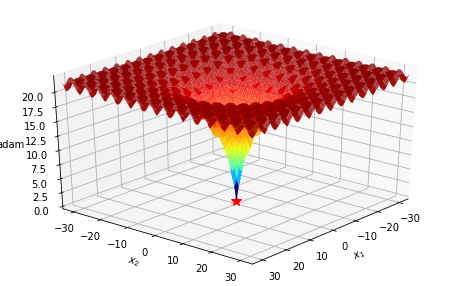

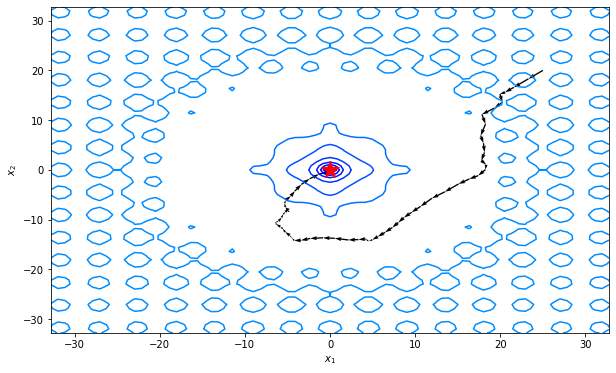

In [245]:
# How close the optimization got to the red star, and how far the min loss was from the global min.
print(ans.get_min_errs())

# The gradient at the end of the optimization. This can be helpful for tuning your learning rate schedule!
last_grad = ans.grad_val(ans.get_xs_losses()[0][-1])
print(last_grad)

# Some visuals
ans.plot3d()
ans.path2d()
#ans.video3d()  # This saves a video to the folder this notebook is in!

#(7.3678272478466685e-12, 8.1829282365009847e-24)

/Users/ishaansrivastava/miniconda2/envs/data100/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


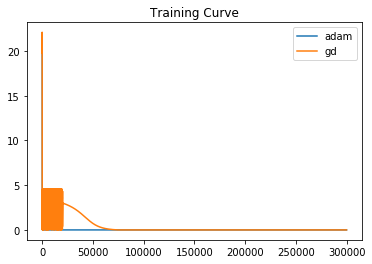

[Method       adam] Final loss: 0.0000, Final x: [-0.0000, -0.0000]
[Method         gd] Final loss: 0.0000, Final x: [0.0000, 0.0000]


In [247]:
ans.compare('gd', lr=lr_boi, num_iters=300000, tol = 0)

## <span style="color:red">Submission: Challenge</span>
<span style="color:red">Place code in the below cells that demonstrates your results for each challenge. Each cell should end with `get_min_errs()` displaying the achieved error.</span>

### Booth function

In [231]:
# Replace parameters here
params = dict(
    method = 'nag',
    lr = lambda x: 0.02,
    num_iters = 400,
)
ans.set_settings(fn_name='booth', x0=np.array([8, 9]), **params)
ans.get_min_errs()

#could use adagrad and adam here as well

(3.1401849173675502e-15, 6.3108872417680944e-30)

### Beale function

In [232]:
# Replace parameters here
params = dict(
    method = 'adagrad',
    lr = lambda x: 5,
    num_iters= 1000000,
    alpha=0.8
)
ans.set_settings(fn_name='beale', x0=np.array([3, 4]), **params)
ans.get_min_errs()

#Note that adam got stuck here

(3.9181953113304346e-12, 2.3139575704826605e-24)

### Rosenbrock function

In [233]:
# Replace parameters here
params = dict(
    method='adam',
    lr= lambda x: 0.5,
    num_iters= 500000,
    tol = 0
)
ans.set_settings(fn_name='rosen2d', x0=np.array([8, 9]), **params)
ans.get_min_errs()

#edited starting point

(2.2204460492503131e-16, 1.1093356479670479e-31)

### Ackley function

In [238]:
# Replace parameters here
params = dict(
    method='adam',
    lr=final_boi,
    num_iters=300000,
    tol = 0
)
ans.set_settings(fn_name='ackley2d', x0=np.array([25, 20]), **params)
ans.get_min_errs()

#Did a lot of hyperparameter tuning here.

/Users/ishaansrivastava/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/ishaansrivastava/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(5.0878457240188813e-11, 1.4390622027349309e-10)

## <span style="color:red">Submission: Project Report</span>

<span style="color:red">Create a report (which will probably be at least half a page) explaining the avenues you explored after the implementation phase of the project, the process you used to select the function values for each combination of functions and initial points, and what you found or learned. You are encouraged to include explanatory images or links to videos generated in the process, showcasing the process you describe or any interesting or unusual phenomena you observe over the course of your investigation!</span>